# Post-Training Quantization and Weights Compression of DeepFloyd IF model with NNCF

The goal of this tutorial is to demonstrate how to speed up the model by applying 8-bit post-training quantization and weights compression from [NNCF](https://github.com/openvinotoolkit/nncf/) (Neural Network Compression Framework) and infer optimized model via OpenVINO™ Toolkit.

> **NOTE**: you should run [238-deep-floyd-if](238-deep-floyd-if.ipynb) notebook first to generate OpenVINO IR model that is used for optimization.

The optimization process contains the following steps:
1. Compress weights of the converted OpenVINO text encoder from [notebook](238-deep-floyd-if.ipynb) with NNCF.
2. Quantize the converted stage_1 and stage_2 U-Nets from [notebook](238-deep-floyd-if.ipynb) with NNCF.
2. Check the model result using the same input data from the [notebook](238-deep-floyd-if.ipynb).
3. Compare model size of converted and optimized models.
4. Compare performance of converted and optimized models.


#### Table of content:
- [Prerequisites](#Prerequisites-Uparrow)
- [Compress text encoder weights](#Compress-text-encoder-weights-Uparrow)
- [Create and initialize quantization](#Create-and-initialize-quantization-Uparrow)
    - [Prepare datasets](#Prepare-datasets-Uparrow)
    - [Quantize first stage U-Net](#Quantize-first-stage-U-Net-Uparrow)
    - [Quantize second stage U-Net](#Quantize-second-stage-U-Net-Uparrow)
- [Run optimized OpenVINO models](#Run-quantized-OpenVINO-model-Uparrow)
    - [Compare file sizes](#Compare-file-sizes-Uparrow)
    - [Compare performance time of the converted and optimized models](#Compare-performance-time-of-the-converted-and-optimized-models-Uparrow)

## Prerequisites [$\Uparrow$](#Table-of-content:)

In [ ]:
%pip install -q datasets

In [ ]:
import nncf
import torch
import openvino as ov

from diffusers import DiffusionPipeline
from diffusers.utils import pt_to_pil
from pathlib import Path
from typing import Any, List

from utils import TextEncoder, UnetFirstStage, UnetSecondStage

checkpoint_variant = 'fp16'
model_dtype = torch.float32
RANDOM_SEED = 42
N_DIFFUSION_STEPS = 50
UNET_2_STEPS = 20

core = ov.Core()

In [2]:
MODEL_DIR = Path('./models')
TEXT_ENCODER_IR_PATH = MODEL_DIR / "encoder_ir.xml"
UNET_I_IR_PATH = MODEL_DIR / "unet_ir_I.xml"
UNET_II_IR_PATH = MODEL_DIR / "unet_ir_II.xml"

if not (TEXT_ENCODER_IR_PATH.exists() and UNET_I_IR_PATH.exists() and UNET_II_IR_PATH.exists()):
    raise RuntimeError('This notebook should be run after 238-deep-floyd-if notebook')

In [3]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

## Compress weights [$\Uparrow$](#Table-of-content:)

Text encoder model consumes ~22 GB of disk space. To avoid running out of memory, we suggest using 8-bit weights compression instead of quantization. An optimized model will show less speed up than a quantized model, but this will significantly reduce the model footprint.

In [25]:
%%time

text_encoder = core.read_model(TEXT_ENCODER_IR_PATH)
text_encoder_optimized = nncf.compress_weights(text_encoder)

TEXT_ENCODER_INT8_IR_PATH = Path("_optimized.".join(TEXT_ENCODER_IR_PATH.as_posix().split(".")))
ov.save_model(text_encoder_optimized, TEXT_ENCODER_INT8_IR_PATH)

CPU times: user 3min 7s, sys: 5.06 s, total: 3min 12s
Wall time: 3min 20s


## Quantize [$\Uparrow$](#Table-of-content:)

### Prepare dataset [$\Uparrow$](#Table-of-content:)

DeepFloyd IF consists of an U-Net model for first and second stages.
First stage U-Net generates 64x64 px image based on text prompt, second stage U-Net generates a 256x256 px image based on image from previous step.
We use a portion of train [LAION2B](https://huggingface.co/datasets/laion/laion2B-en) dataset from Hugging Face as calibration data.
LAION2B is the English subset of the [LAION5B](https://laion.ai/blog/laion-5b/) dataset, contains over 2 billion objects.

In [5]:
import numpy as np
from datasets import load_dataset

np.random.seed(RANDOM_SEED)

def get_negative_prompt():
    negative_prompts = [
        "amateur", "blurred", "deformed", "disfigured", "disgusting", "jpeg artifacts", "low contrast",
        "low quality", "low saturation", "mangled", "morbid", "mutilated", "mutation",
        "out of frame", "out of frame", "ugly", "uncentered", "underexposed", "unreal",
    ]
    num_elements = np.random.randint(2, 6)
    random_elements = np.random.choice(negative_prompts, num_elements)
    return [" ".join(random_elements)]

def prepare_calibration_data(dataloader, stage_1):
    """
    This function prepares calibration data from a dataloader for a specified number of initialization steps.
    It iterates over the dataloader, fetching batches and storing the relevant data.
    """
    data = []
    for batch in dataloader:
        prompt = batch["TEXT"]
        negative_prompt = get_negative_prompt()
        prompt_embeds, negative_embeds = stage_1.encode_prompt(prompt, negative_prompt=negative_prompt)
        data.append((prompt_embeds, negative_embeds))
    return data


def prepare_dataset(stage_1, opt_init_steps=300):
    """
    Prepares a text dataset for quantization.
    """
    dataset = load_dataset("laion/laion2B-en", streaming=True, split="train")
    train_dataset = dataset.shuffle(seed=RANDOM_SEED, buffer_size=1000).take(opt_init_steps)
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
    calibration_data = prepare_calibration_data(dataloader, stage_1)
    return calibration_data

In [6]:
%%time

generator = torch.manual_seed(RANDOM_SEED)
opt_init_steps = 300
selection_prob = 0.5
prompts_number = np.ceil(opt_init_steps // (min(N_DIFFUSION_STEPS, UNET_2_STEPS) * selection_prob))

stage_1 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-M-v1.0",
    variant=checkpoint_variant,
    torch_dtype=model_dtype
)
encoded_prompts = prepare_dataset(stage_1, int(prompts_number))

safety_checker/model.safetensors not found

A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/pytorch_model.fp16-00002-of-00002.bin, text_encoder/pytorch_model.fp16-00001-of-00002.bin, unet/diffusion_pytorch_model.fp16.bin]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.bin, safety_checker/pytorch_model.bin
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/128 [00:00<?, ?it/s]

CPU times: user 32min 10s, sys: 2min 2s, total: 34min 13s
Wall time: 44.5 s


To collect intermediate model inputs for calibration we should customize `CompiledModel`.

In [7]:
class CompiledModelDecorator(ov.CompiledModel):
    def __init__(self, compiled_model, prob: float, data_cache: List[Any] = []):
        super().__init__(compiled_model)
        self.data_cache = data_cache
        self.prob = np.clip(prob, 0, 1)

    def __call__(self, *args, **kwargs):
        if np.random.rand() >= self.prob:
            self.data_cache.append(*args)
        return super().__call__(*args, **kwargs)

In [8]:
stage_1.unet = UnetFirstStage(
    UNET_I_IR_PATH,
    stage_1.unet.config,
    dtype=model_dtype,
    device=device.value
)
stage_1.set_progress_bar_config(disable=True)

stage_1_data_cache = []
stage_1.unet.unet_openvino = CompiledModelDecorator(stage_1.unet.unet_openvino, prob=selection_prob, data_cache=stage_1_data_cache)

generator = torch.manual_seed(RANDOM_SEED)
stage_2_inputs = []  # to speed up dataset preparation for stage 2 U-Net we can collect several images below
for data in encoded_prompts:
    prompt_embeds, negative_embeds = data
    image = stage_1(prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds,
                    generator=generator, output_type="pt", num_inference_steps=N_DIFFUSION_STEPS).images
    stage_2_inputs.append((image, prompt_embeds, negative_embeds))

    if len(stage_1_data_cache) >= opt_init_steps:
        break

### Quantize first stage U-Net [$\Uparrow$](#Table-of-content:)

In [9]:
%%time

ov_model = core.read_model(UNET_I_IR_PATH)
stage_1_calibration_dataset = nncf.Dataset(stage_1_data_cache, lambda x: x)

quantized_model = nncf.quantize(
    model=ov_model,
    calibration_dataset=stage_1_calibration_dataset,
    model_type=nncf.ModelType.TRANSFORMER,
    advanced_parameters=nncf.AdvancedQuantizationParameters(smooth_quant_alpha=0.25)
)

UNET_I_INT8_PATH = "_optimized.".join(UNET_I_IR_PATH.as_posix().split("."))
ov.save_model(quantized_model, UNET_I_INT8_PATH)

Applying Fast Bias correction: 100%|██████████| 268/268 [02:52<00:00,  1.56it/s]


CPU times: user 1h 26min 51s, sys: 3min 6s, total: 1h 29min 57s
Wall time: 13min 20s


In [10]:
%%time

from tqdm.notebook import tqdm

start = len(stage_2_inputs)
for i, data in tqdm(enumerate(encoded_prompts[start:])):
    prompt_embeds, negative_embeds = data
    image = stage_1(prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds,
                    generator=generator, output_type="pt", num_inference_steps=N_DIFFUSION_STEPS).images
    stage_2_inputs.append((image, prompt_embeds, negative_embeds))

0it [00:00, ?it/s]

CPU times: user 1h 40min 41s, sys: 2min 27s, total: 1h 43min 9s
Wall time: 3min 58s


In [11]:
%%time

generator = torch.manual_seed(RANDOM_SEED)
opt_init_steps = 300

stage_2 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-II-M-v1.0",
    text_encoder=None,
    variant=checkpoint_variant,
    torch_dtype=model_dtype
)
stage_2.set_progress_bar_config(disable=True)

stage_2.unet = UnetSecondStage(
    UNET_II_IR_PATH,
    stage_2.unet.config,
    dtype=model_dtype,
    device=device.value
)
stage_2_data_cache = []
stage_2.unet.unet_openvino = CompiledModelDecorator(stage_2.unet.unet_openvino, prob=selection_prob, data_cache=stage_2_data_cache)

for data in stage_2_inputs:
    image, prompt_embeds, negative_embeds = data
    image = stage_2(image=image, prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds,
                    generator=generator, output_type="pt", num_inference_steps=UNET_2_STEPS).images

    if len(stage_2_data_cache) >= opt_init_steps:
        break


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 7h 2min 34s, sys: 3min 57s, total: 7h 6min 32s
Wall time: 15min 20s


### Quantize second stage U-Net [$\Uparrow$](#Table-of-content:)

In [12]:
%%time

ov_model = core.read_model(UNET_II_IR_PATH)

calibration_dataset = nncf.Dataset(stage_2_data_cache, lambda x: x)
quantized_model = nncf.quantize(
    model=ov_model,
    calibration_dataset=calibration_dataset,
    model_type=nncf.ModelType.TRANSFORMER,
)

UNET_II_INT8_PATH = "_optimized.".join(UNET_II_IR_PATH.as_posix().split("."))
ov.save_model(quantized_model, UNET_II_INT8_PATH)

Applying Fast Bias correction: 100%|██████████| 245/245 [03:27<00:00,  1.18it/s]


CPU times: user 7h 46min 16s, sys: 8min 41s, total: 7h 54min 58s
Wall time: 38min 57s


## Run optimized OpenVINO model [$\Uparrow$](#Table-of-content:)

Let us check predictions with the optimized OpenVINO DeepFloyd IF model result using the same input data from the [1st notebook](238-deep-floyd-if.ipynb).

In [13]:
prompt = 'ultra close color photo portrait of rainbow owl with deer horns in the woods'
negative_prompt = 'blurred unreal uncentered occluded'

safety_checker/model.safetensors not found

A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/pytorch_model.fp16-00002-of-00002.bin, text_encoder/pytorch_model.fp16-00001-of-00002.bin, unet/diffusion_pytorch_model.fp16.bin]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.bin, safety_checker/pytorch_model.bin
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The model has been loaded


  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 3min 48s, sys: 32.4 s, total: 4min 21s
Wall time: 20.2 s


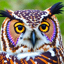

In [14]:
%%time

stage_1 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-M-v1.0",
    variant=checkpoint_variant,
    torch_dtype=model_dtype
)

# Initialize the First Stage U-Net wrapper class
stage_1.unet = UnetFirstStage(
    UNET_I_INT8_PATH,
    stage_1.unet.config,
    dtype=model_dtype,
    device=device.value
)

stage_1.text_encoder = TextEncoder(TEXT_ENCODER_INT8_IR_PATH, dtype=model_dtype, device=device.value)
print('The model has been loaded')

# Generate text embeddings
prompt_embeds, negative_embeds = stage_1.encode_prompt(prompt, negative_prompt=negative_prompt)

# Fix PRNG seed
generator = torch.manual_seed(RANDOM_SEED)

# Inference
image = stage_1(prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds,
                generator=generator, output_type="pt", num_inference_steps=N_DIFFUSION_STEPS).images

# Show the image
pt_to_pil(image)[0]


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The model has been loaded


  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 5min 57s, sys: 11.6 s, total: 6min 8s
Wall time: 19 s


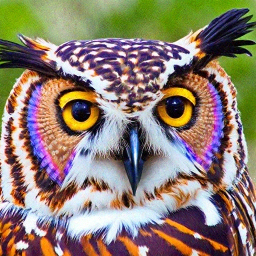

In [15]:
%%time

stage_2 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-II-M-v1.0",
    text_encoder=None,
    variant=checkpoint_variant,
    torch_dtype=model_dtype
)

# Initialize the Second Stage U-Net wrapper class
stage_2.unet = UnetSecondStage(
    UNET_II_INT8_PATH,
    stage_2.unet.config,
    dtype=model_dtype,
    device=device.value
)
print('The model has been loaded')

image = stage_2(
    image=image, prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds,
    generator=generator, output_type="pt", num_inference_steps=UNET_2_STEPS).images

# Show the image
pil_image = pt_to_pil(image)[0]
pil_image

single-image-super-resolution-1032 already downloaded to models


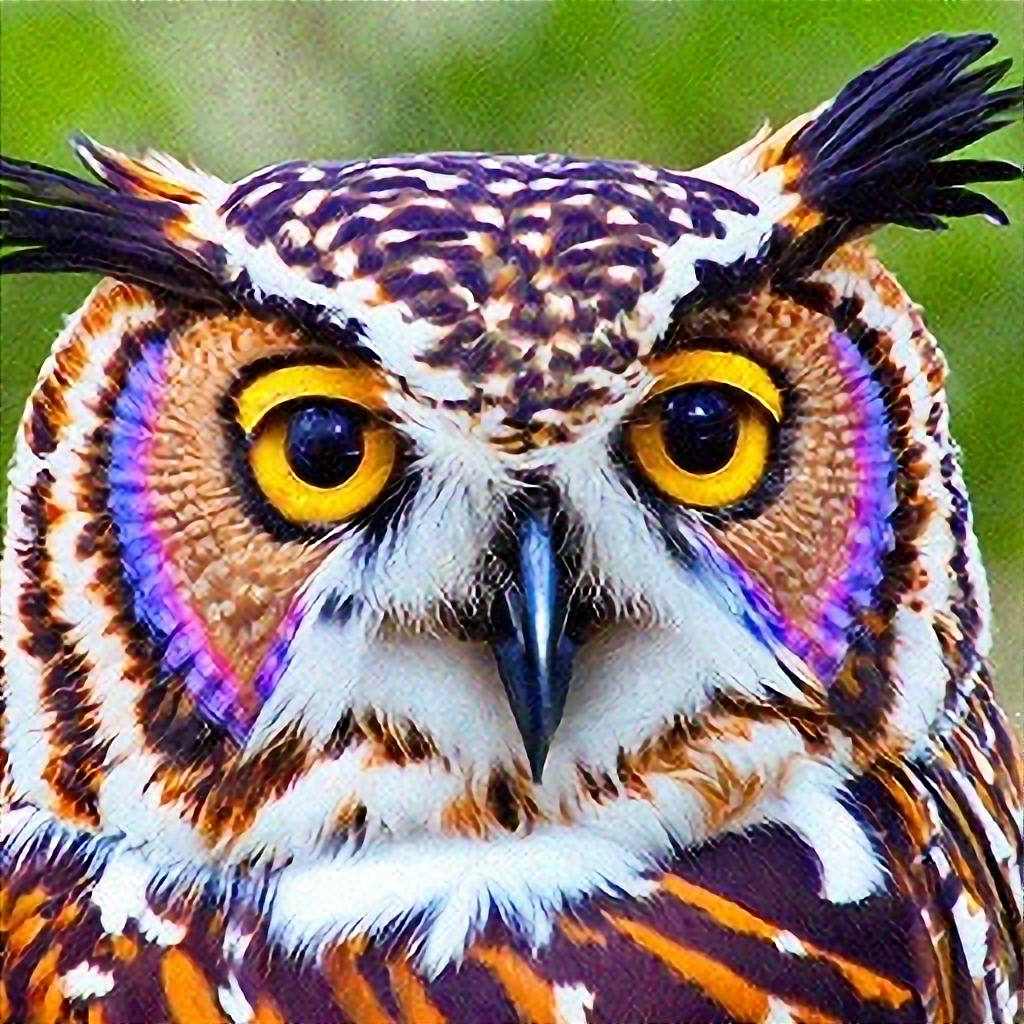

In [16]:

import cv2
import numpy as np
from utils import convert_result_to_image, download_omz_model

# 1032: 4x superresolution, 1033: 3x superresolution
model_name = 'single-image-super-resolution-1032'
download_omz_model(model_name, MODEL_DIR)

sr_model_xml_path = MODEL_DIR / f'{model_name}.xml'
model = core.read_model(model=sr_model_xml_path)
model.reshape({
    0: [1, 3, 256, 256],
    1: [1, 3, 1024, 1024]
})
compiled_sr_model = core.compile_model(model=model, device_name=device.value)

original_image = np.array(pil_image)
bicubic_image = cv2.resize(
    src=original_image, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC
)

# Reshape the images from (H,W,C) to (N,C,H,W) as expected by the model.
input_image_original = np.expand_dims(original_image.transpose(2, 0, 1), axis=0)
input_image_bicubic = np.expand_dims(bicubic_image.transpose(2, 0, 1), axis=0)

# Model Inference
result = compiled_sr_model(
    [input_image_original, input_image_bicubic]
)[compiled_sr_model.output(0)]

img = convert_result_to_image(result)
img

> **NOTE**: Accuracy of quantized models can generally be improved by increasing calibration dataset size. For U-Net models, you can collect a more diverse dataset by using a smaller `selection_prob` value, but this will increase the dataset collection time.

#### Compare file sizes [$\Uparrow$](#Table-of-content:)

Let's calculate the compression rate of the optimized IRs file size relative to the FP16 OpenVINO models file size

In [17]:
def calculate_compression_rate(ov_model_path):
    fp16_ir_model_size = Path(ov_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
    int8_model_path = "_optimized.".join(ov_model_path.as_posix().split("."))
    quantized_model_size = Path(int8_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
    print(f'{ov_model_path.as_posix().split(".")[0]}')
    print(f"    * FP16 IR model size: {fp16_ir_model_size:.2f} MB")
    print(f"    * INT8 model size: {quantized_model_size:.2f} MB")
    print(f"    * Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

In [18]:
for model_path in [TEXT_ENCODER_IR_PATH, UNET_I_IR_PATH, UNET_II_IR_PATH]:
    calculate_compression_rate(model_path)

models/encoder_ir
    * FP16 IR model size: 22008.21 MB
    * INT8 model size: 4547.42 MB
    * Model compression rate: 4.840
models/unet_ir_I
    * FP16 IR model size: 1417.56 MB
    * INT8 model size: 355.16 MB
    * Model compression rate: 3.991
models/unet_ir_II
    * FP16 IR model size: 1758.82 MB
    * INT8 model size: 440.49 MB
    * Model compression rate: 3.993


#### Compare performance time of the converted and optimized models [$\Uparrow$](#Table-of-content:)

To measure the inference performance of OpenVINO FP16 and INT8 models, use [Benchmark Tool](https://docs.openvino.ai/2023.0/openvino_inference_engine_tools_benchmark_tool_README.html).

> **NOTE**: For more accurate performance, run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app --help` to see an overview of all command-line options.

In [19]:
import re

def get_fps(benchmark_output: str):
    parsed_output = [line for line in benchmark_output if 'Throughput:' in line]
    fps = re.findall(r"\d+\.\d+", parsed_output[0])[0]
    return fps

Text encoder

In [26]:
benchmark_output = !benchmark_app -m $TEXT_ENCODER_IR_PATH -d $device.value -api async
original_fps = get_fps(benchmark_output)
print(f"FP16 Text Encoder Throughput: {original_fps} FPS")

benchmark_output = !benchmark_app -m $TEXT_ENCODER_INT8_IR_PATH -d $device.value -api async
optimized_fps = get_fps(benchmark_output)
print(f"INT8 Text Encoder Throughput: {optimized_fps} FPS")
print(f"Text encoder speed up: {float(optimized_fps) / float(original_fps)}")

FP16 Text Encoder Throughput: 5.62 FPS
INT8 Text Encoder Throughput: 5.86 FPS
Text encoder speed up: 1.0427046263345197


First stage UNet

In [27]:
benchmark_output = !benchmark_app -m $UNET_I_IR_PATH -d $device.value -api async
original_fps = get_fps(benchmark_output)
print(f"FP16 1 stage U-Net Throughput: {original_fps} FPS")

benchmark_output = !benchmark_app -m $UNET_I_INT8_PATH -d $device.value -api async
optimized_fps = get_fps(benchmark_output)
print(f"INT8 1 stage U-Net Throughput: {optimized_fps} FPS")
print(f"1 stage U-Net speed up: {float(optimized_fps) / float(original_fps)}")

FP16 1 stage U-Net Throughput: 21.57 FPS
INT8 1 stage U-Net Throughput: 49.74 FPS
1 stage U-Net speed up: 2.3059805285118222


Second stage UNet

In [29]:
benchmark_output = !benchmark_app -m $UNET_II_IR_PATH -d $device.value -api async
original_fps = get_fps(benchmark_output)
print(f"FP16 2 stage U-Net Throughput: {original_fps} FPS")

benchmark_output = !benchmark_app -m $UNET_II_INT8_PATH -d $device.value -api async
optimized_fps = get_fps(benchmark_output)
print(f"INT8 2 stage U-Net Throughput: {optimized_fps} FPS")
print(f"2 stage U-Net speed up: {float(optimized_fps) / float(original_fps)}")

FP16 2 stage U-Net Throughput: 2.92 FPS
INT8 2 stage U-Net Throughput: 7.90 FPS
2 stage U-Net speed up: 2.705479452054795
